<a href="https://colab.research.google.com/github/mukimsoft/Retina_Segmentation_EfficientNet-B4-_DenseNet121/blob/main/retina_segmentation_EfficientNet_B4__DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick Checklist

- Generate a Kaggle API token once and keep `kaggle.json` in `~/.kaggle/`; `opendatasets` will reuse it without any prompts.
- The notebook automatically downloads the dataset into `/content/diabetic-retinopathy-image-dataset` if it is missing.
- Segmentation + Localization folders stay in their original structure; we just point to both roots and merge the samples.
- Models trained here: **EfficientNet-B4**, and **DenseNet121**.
- A comparison table highlights the best performer.

In [ ]:
%%capture
!pip install --upgrade pip
!pip install opendatasets segmentation-models-pytorch==0.3.3 timm==0.9.16 albumentations==1.4.3 opencv-python matplotlib pandas

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install opendatasets

import opendatasets as od

od.download("https://www.kaggle.com/datasets/dankok/diabetic-retinopathy-image-dataset")


  Using cached opendatasets-0.1.22-py3-none-any.whl.metadata (9.2 kB)
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: malihasanjana
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dankok/diabetic-retinopathy-image-dataset


100%|██████████| 408M/408M [00:02<00:00, 143MB/s] 


In [ ]:
from pathlib import Path
import opendatasets as od

DATASET_URL = "https://www.kaggle.com/datasets/dankok/diabetic-retinopathy-image-dataset"
dataset_path = Path("/content/diabetic-retinopathy-image-dataset")

if not dataset_path.exists():
    od.download(DATASET_URL, data_dir="/content")
    print("Downloaded dataset to /content.")
else:
    print("Dataset already present; skipping download.")

print("Top-level folders:")
for child in sorted(dataset_path.iterdir()):
    if child.is_dir():
        print(f"- {child.name}")

Dataset already present; skipping download.
Top-level folders:
- Disease_Grading
- Localization
- Segmentation


# Merge Dataset

In [ ]:
import random
from typing import List, Dict
import numpy as np
import torch
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

segmentation_root = dataset_path / "Segmentation"
localization_root = dataset_path / "Localization"
if (localization_root / "Localization").exists():
    localization_root = localization_root / "Localization"

seg_image_train_root = segmentation_root / "Original_Images" / "Training Set"
seg_image_test_root = segmentation_root / "Original_Images" / "Testing Set"
seg_mask_train_root = segmentation_root / "Segmentation_Groundtruths" / "Training Set"
seg_mask_test_root = segmentation_root / "Segmentation_Groundtruths" / "Testing Set"

loc_image_train_root = localization_root / "Original_Images" / "Training Set" if localization_root.exists() else None
loc_image_test_root = localization_root / "Original_Images" / "Testing Set" if localization_root.exists() else None
loc_mask_train_root = localization_root / "Groundtruths" / "Training Set" if localization_root.exists() else None
loc_mask_test_root = localization_root / "Groundtruths" / "Testing Set" if localization_root.exists() else None

def gather_image_paths(directory: Path) -> List[Path]:
    if directory is None or not directory.exists():
        return []
    paths: List[Path] = []
    for pattern in ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff"):
        paths.extend(directory.glob(pattern))
    return sorted(paths)

def collect_mask_types(mask_dirs: List[Path]) -> List[str]:
    names = set()
    for root in mask_dirs:
        if root and root.exists():
            for child in root.iterdir():
                if child.is_dir():
                    names.add(child.name)
    return sorted(names)

def create_samples(image_dir: Path, mask_dir: Path) -> List[Dict]:
    if image_dir is None or not image_dir.exists():
        return []
    mask_roots = [mask_dir] if mask_dir and mask_dir.exists() else []
    return [{"image": img_path, "mask_roots": mask_roots} for img_path in gather_image_paths(image_dir)]

mask_types = collect_mask_types([seg_mask_train_root, seg_mask_test_root, loc_mask_train_root, loc_mask_test_root])
if not mask_types:
    raise RuntimeError("No mask folders detected. Please verify the dataset structure.")

seg_train_samples = create_samples(seg_image_train_root, seg_mask_train_root)
loc_train_samples = create_samples(loc_image_train_root, loc_mask_train_root)
combined_train_samples = seg_train_samples + loc_train_samples

test_samples = create_samples(seg_image_test_root, seg_mask_test_root) + create_samples(loc_image_test_root, loc_mask_test_root)

if not combined_train_samples:
    raise RuntimeError("Training split is empty. Confirm the dataset download finished correctly.")

if len(combined_train_samples) > 1:
    train_samples, val_samples = train_test_split(combined_train_samples, test_size=0.2, random_state=42, shuffle=True)
else:
    train_samples, val_samples = combined_train_samples, test_samples if test_samples else combined_train_samples

if not val_samples:
    val_samples = combined_train_samples.copy()

print(f"Segmentation train images: {len(seg_train_samples)}")
print(f"Localization train images: {len(loc_train_samples)}")
print(f"Merged train pool: {len(combined_train_samples)}")
print(f"Validation samples: {len(val_samples)}")
print(f"Mask channels: {mask_types}")

Segmentation train images: 54
Localization train images: 413
Merged train pool: 467
Validation samples: 94
Mask channels: ['Haemorrhages', 'Hard Exudates', 'Microaneurysms', 'Optic Disc', 'Soft Exudates']


# Data Augmentation

In [ ]:
from torch.utils.data import Dataset, DataLoader

def build_transforms(image_size: int, augment: bool) -> A.Compose:
    steps = [A.Resize(image_size, image_size)]
    if augment:
        steps += [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
        ]
    steps.append(A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0))
    return A.Compose(steps)

class IDRiDSegmentationDataset(Dataset):
    def __init__(self, samples, mask_types, image_size=384, augment=False):
        self.samples = samples
        self.mask_types = mask_types
        self.transform = build_transforms(image_size, augment)
        self.image_size = image_size

    def __len__(self):
        return len(self.samples)

    def _load_mask_channel(self, mask_roots, stem, mask_type, size):
        for root in mask_roots:
            channel_dir = root / mask_type
            if not channel_dir.exists():
                continue
            matches = sorted(channel_dir.glob(f"{stem}*"))
            if matches:
                mask = cv2.imread(str(matches[0]), cv2.IMREAD_UNCHANGED)
                if mask is not None:
                    if mask.shape[:2] != size:
                        mask = cv2.resize(mask, size[::-1], interpolation=cv2.INTER_NEAREST)
                    return (mask > 0).astype(np.float32)
        return np.zeros(size, dtype=np.float32)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = sample["image"]
        mask_roots = sample["mask_roots"]
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        size = image.shape[:2]
        mask = np.stack([self._load_mask_channel(mask_roots, image_path.stem, mask_type, size) for mask_type in self.mask_types], axis=-1)
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"].transpose(2, 0, 1).astype(np.float32)
        mask = transformed["mask"].transpose(2, 0, 1).astype(np.float32)
        return torch.from_numpy(image), torch.from_numpy(mask)

IMAGE_SIZE = 384
BATCH_SIZE = 2
PIN_MEMORY = torch.cuda.is_available()

train_dataset = IDRiDSegmentationDataset(train_samples, mask_types, image_size=IMAGE_SIZE, augment=True)
val_dataset = IDRiDSegmentationDataset(val_samples, mask_types, image_size=IMAGE_SIZE, augment=False)
test_dataset = IDRiDSegmentationDataset(test_samples, mask_types, image_size=IMAGE_SIZE, augment=False) if test_samples else None
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY) if test_dataset else None

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

Train samples: 373 | Val samples: 94 | Test samples: 130
Train batches: 187 | Val batches: 47


In [ ]:
!pip install segmentation-models-pytorch

# Dice-Coefficient, Accuracy, Epoch

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss()

def dice_coefficient(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    intersection = torch.sum(probs * targets, dim=(1, 2, 3))
    sums = torch.sum(probs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))
    dice = (2 * intersection + eps) / (sums + eps)
    return dice.mean()

def pixel_accuracy(logits, targets):
    preds = (torch.sigmoid(logits) > 0.5).float()
    correct = (preds == targets).float().mean(dim=(1, 2, 3))
    return correct.mean()

def run_epoch(loader, model, optimizer=None, train=True):
    if loader is None or len(loader.dataset) == 0:
        return 0.0, 0.0, 0.0
    model.train() if train else model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    total_items = 0
    with torch.set_grad_enabled(train):
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            logits = model(images)
            loss = criterion(logits, masks)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            batch = images.size(0)
            total_items += batch
            total_loss += loss.item() * batch
            total_dice += dice_coefficient(logits.detach(), masks).item() * batch
            total_acc += pixel_accuracy(logits.detach(), masks).item() * batch
    return total_loss / total_items, total_dice / total_items, total_acc / total_items

In [ ]:
EPOCHS = 5
LR = 1e-4

model_factories = {
    "EfficientNet-B4 U-Net": lambda: smp.Unet(
        encoder_name="timm-efficientnet-b4",
        encoder_weights="imagenet",
        in_channels=3,
        classes=len(mask_types),
    ),
    "DenseNet121 U-Net": lambda: smp.Unet(
        encoder_name="densenet121",
        encoder_weights="imagenet",
        in_channels=3,
        classes=len(mask_types),
    ),

}

results = []
model_histories = {}

for model_name, build_model in model_factories.items():
    print(f"\nTraining {model_name}")
    model = build_model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    best_acc = 0.0
    best_dice = 0.0
    best_checkpoint = None
    history = []
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_dice, train_acc = run_epoch(train_loader, model, optimizer=optimizer, train=True)
        val_loss, val_dice, val_acc = run_epoch(val_loader, model, train=False)
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_dice": train_dice,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_dice": val_dice,
            "val_acc": val_acc,
        })
        print(
            f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
            f"train_dice={train_dice:.4f} val_dice={val_dice:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
        if val_dice > best_dice:
            best_dice = val_dice
        if val_acc >= best_acc:
            best_acc = val_acc
            best_checkpoint = f"{model_name.lower().replace(' ', '_').replace('-', '')}_best.pt"
            torch.save(model.state_dict(), best_checkpoint)
    if best_checkpoint is None:
        best_checkpoint = f"{model_name.lower().replace(' ', '_').replace('-', '')}_final.pt"
        torch.save(model.state_dict(), best_checkpoint)
    results.append({
        "Model": model_name,
        "Best Accuracy": best_acc,
        "Best Dice": best_dice,
        "Checkpoint": best_checkpoint,
    })
    model_histories[model_name] = history


Training EfficientNet-B4 U-Net


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/5 | train_loss=0.5382 val_loss=0.3481 train_dice=0.0014 val_dice=0.0015 train_acc=0.7667 val_acc=0.9811
Epoch 2/5 | train_loss=0.2503 val_loss=0.1745 train_dice=0.0014 val_dice=0.0015 train_acc=0.9959 val_acc=0.9988
Epoch 3/5 | train_loss=0.1269 val_loss=0.0923 train_dice=0.0014 val_dice=0.0015 train_acc=0.9989 val_acc=0.9990
Epoch 4/5 | train_loss=0.0718 val_loss=0.0562 train_dice=0.0014 val_dice=0.0019 train_acc=0.9991 val_acc=0.9990
Epoch 5/5 | train_loss=0.0458 val_loss=0.0380 train_dice=0.0015 val_dice=0.0021 train_acc=0.9991 val_acc=0.9990

Training DenseNet121 U-Net


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1/5 | train_loss=0.4454 val_loss=0.2747 train_dice=0.0017 val_dice=0.0018 train_acc=0.8952 val_acc=0.9980
Epoch 2/5 | train_loss=0.1773 val_loss=0.1147 train_dice=0.0017 val_dice=0.0017 train_acc=0.9989 val_acc=0.9990
Epoch 3/5 | train_loss=0.0827 val_loss=0.0606 train_dice=0.0018 val_dice=0.0017 train_acc=0.9991 val_acc=0.9990
Epoch 4/5 | train_loss=0.0478 val_loss=0.0388 train_dice=0.0018 val_dice=0.0031 train_acc=0.9991 val_acc=0.9990
Epoch 5/5 | train_loss=0.0317 val_loss=0.0264 train_dice=0.0023 val_dice=0.0016 train_acc=0.9991 val_acc=0.9990


## Accuracy Snapshot


In [ ]:
if results:
    print("Best validation accuracy per model (pixel-wise):")
    for entry in results:
        acc_pct = entry["Best Accuracy"] * 100
        dice_pct = entry["Best Dice"] * 100
        print(f"- {entry['Model']}: accuracy={acc_pct:.2f}% | dice={dice_pct:.2f}%")
else:
    print("Run the training cell above to compute accuracies.")

Best validation accuracy per model (pixel-wise):
- EfficientNet-B4 U-Net: accuracy=99.90% | dice=0.21%
- DenseNet121 U-Net: accuracy=99.90% | dice=0.31%


In [ ]:
if results:
    results_df = pd.DataFrame(results)
    results_df["Best Accuracy (%)"] = (results_df["Best Accuracy"] * 100).round(2)
    results_df["Best Dice (%)"] = (results_df["Best Dice"] * 100).round(2)
    display(
        results_df[["Model", "Best Accuracy (%)", "Best Dice (%)"]]
        .sort_values("Best Accuracy (%)", ascending=False)
        .reset_index(drop=True)
    )
else:
    print("Run the training cell above to populate comparison metrics.")

,Model,Best Accuracy (%),Best Dice (%)
0,EfficientNet-B4 U-Net,99.9,0.21
1,DenseNet121 U-Net,99.9,0.31


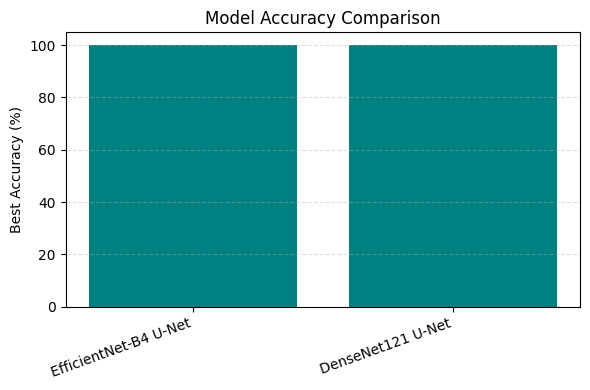

In [ ]:
if results:
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(6, 4))
    plt.bar(results_df["Model"], results_df["Best Accuracy"] * 100, color="teal")
    plt.ylabel("Best Accuracy (%)")
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=20, ha="right")
    plt.ylim(0, max(1.0, (results_df["Best Accuracy"] * 100).max() + 5))
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
else:
    print("Train at least one model before plotting accuracy.")

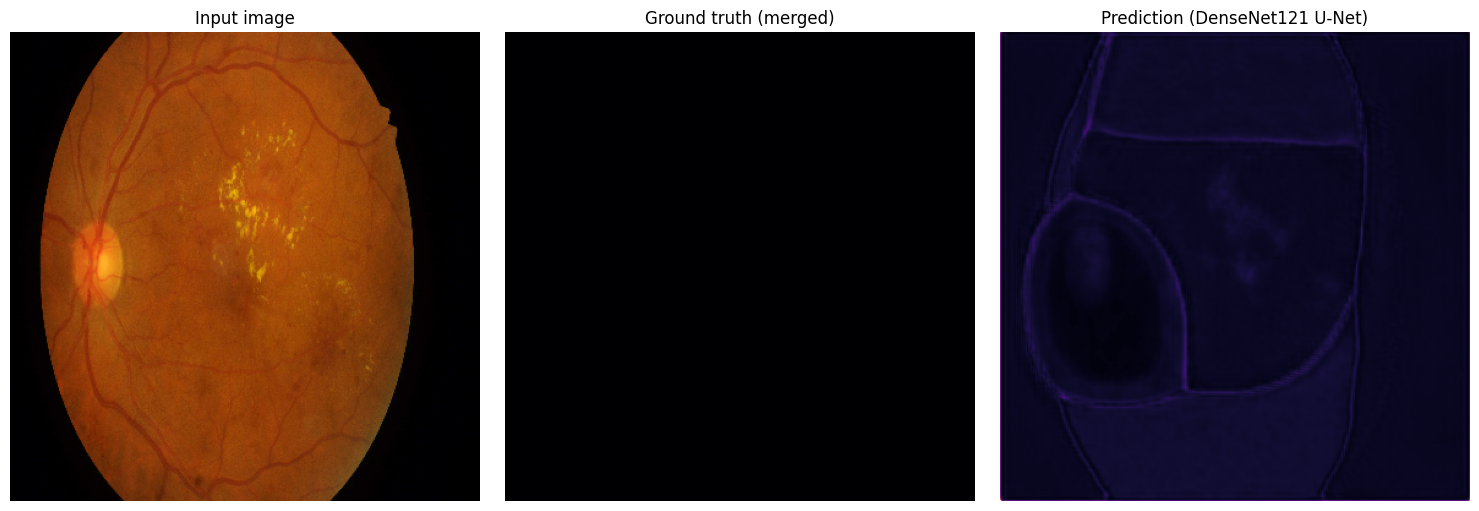

In [ ]:
import numpy as np

def show_random_prediction():
    if not results or len(val_dataset) == 0:
        print("Train the models and ensure the validation split has samples before visualizing.")
        return
    best_result = max(results, key=lambda row: row["Best Accuracy"])
    best_model = model_factories[best_result["Model"]]().to(device)
    best_model.load_state_dict(torch.load(best_result["Checkpoint"], map_location=device))
    best_model.eval()
    sample_idx = random.randrange(len(val_dataset))
    image_tensor, mask_tensor = val_dataset[sample_idx]
    with torch.no_grad():
        prediction = torch.sigmoid(best_model(image_tensor.unsqueeze(0).to(device)))[0].cpu().numpy()
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)
    gt_mask = np.clip(mask_tensor.numpy().sum(axis=0), 0.0, 1.0)
    pred_mask = np.clip(prediction.sum(axis=0), 0.0, 1.0)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Input image")
    axes[1].imshow(gt_mask, cmap="magma")
    axes[1].set_title("Ground truth (merged)")
    axes[2].imshow(pred_mask, cmap="magma")
    axes[2].set_title(f"Prediction ({best_result['Model']})")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()

show_random_prediction()

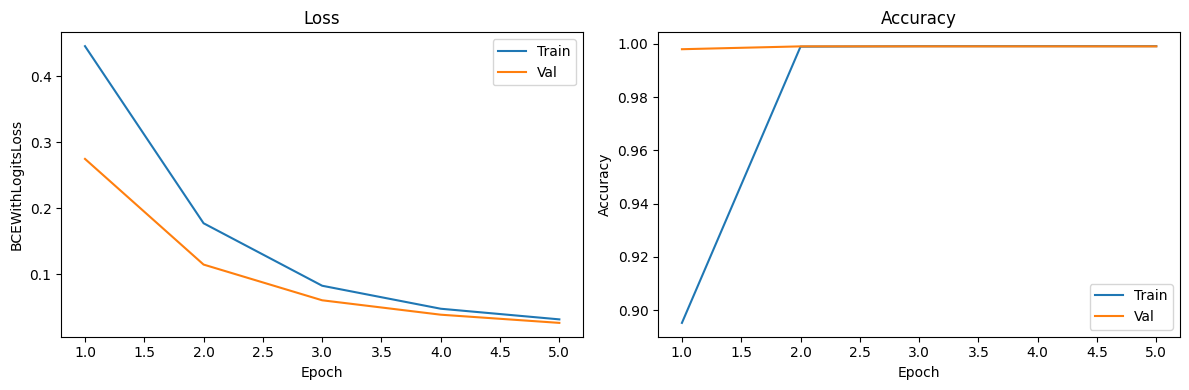

In [ ]:
import matplotlib.pyplot as plt

epochs = [entry["epoch"] for entry in history]
train_loss_curve = [entry["train_loss"] for entry in history]
val_loss_curve = [entry["val_loss"] for entry in history]
train_acc_curve = [entry["train_acc"] for entry in history]
val_acc_curve = [entry["val_acc"] for entry in history]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_curve, label="Train")
plt.plot(epochs, val_loss_curve, label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_curve, label="Train")
plt.plot(epochs, val_acc_curve, label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()